In [1]:
import numpy as np
from scipy.linalg import logm

# fix seed
seed=0 
np.random.seed(seed)

# fix output array
np.set_printoptions(suppress=True,precision=2)

# Deep Policy Gradient (PG)


In this notebook, our goal is to implement the REINFORCE algorithm for policy gradient using [JAX](https://jax.readthedocs.io/en/latest/). 

We will apply this RL algorithm to control a single quantum bit of information (qubit) in the presence of noise and spontaneous emission.  

## The REINFORCE Algorithm

The reinforcement learning objective $J$ is the expected total return, following the policy $\pi$. If the transition probability is denoted by $p(s'|s,a)$, and the initial state distribution is $p(s_0)$, the probability for a trajectory $\tau = (s_0,a_0,r_1,s_1,a_1,\dots,s_{T-1},a_{T-1},r_T,s_T)$ to occur can be written as

$$ 
P_\pi(\tau) = p(s_0)\prod_{t=1}^T \pi(a_t|s_t)p(s_{t+1}|s_t,a_t). 
$$

The RL objective then takes the form

$$
J = \mathrm{E}_{\tau\sim P_\pi} \left[ G(\tau) | S_{t=0}=s_0 \right],\quad G(\tau)=\sum_{t=1}^T r(s_t,a_t).
$$

Policy gradient methods in RL approximate directly the policy $\pi\approx\pi_\theta$ using a variational ansatz, parametrized by some unknown parameters $\theta$. The goal is then to find those optimal parameters $\theta$, which optimize the RL objective $J(\theta)$. To define an update rule for $\theta$, we can use gradient ascent. This requires us to evaluate the gradient of the RL objective w.r.t. the parameters $\theta$:

$$
\nabla_\theta J(\theta) = \nabla_\theta \mathrm{E}_{\tau\sim P_\pi} \left[ \sum_{t=1}^T r(s_t,a_t) | S_{t=0}=s_0 \right] 
= \int\mathcal{D}\tau\; \nabla_\theta P_{\pi_\theta}(\tau) G(\tau).
$$
In a model-free setting, we don't have access to the transition probabilities $p(s'|s,a)$ and this requires us to be able to estimate the gradients from samples. This can be accomplished by noticing that $\nabla_\theta P_{\pi_\theta} = P_{\pi_\theta} \nabla_\theta \log P_{\pi_\theta}$ (almost everywhere, i.e. up to a set of measure zero):

$$
\nabla_\theta J(\theta) = \int\mathcal{D}\tau\; \nabla_\theta P_{\pi_\theta}(\tau) G(\tau) = \int\mathcal{D}\tau\; P_{\pi_\theta}(\tau) \nabla_\theta \log P_{\pi_\theta}(\tau) G(\tau) = \mathrm{E}_{\tau\sim P_\pi} \left[\nabla_\theta \log P_{\pi_\theta}(\tau) G(\tau)\right].
$$
Since the initial state distribution and the transition probabilities are independent of $\theta$, using the definition of $P_{\pi_\theta}$, we see that $\nabla_\theta P_{\pi_\theta}(\tau) = \nabla_\theta \pi_\theta(\tau)$ where $\pi_\theta(\tau) = \prod_{t=1}^T \pi(a_t|s_t)$. 

We can now use Monte Carlo sampling to estimate the gradients directly from a sample of trajectories $\{\tau_j\}_{j=1}^N$:
$$
\nabla_\theta J(\theta) = \mathrm{E}_{\tau\sim P_\pi} \left[\nabla_\theta \log \pi_\theta(\tau) G(\tau)\right]
\approx \frac{1}{N}\sum_{j=1}^N \nabla_\theta \log \pi_\theta(\tau_j) G(\tau_j).
$$

To alleviate the problem with the large variance of the gradient estimate, one can introduce a baseline $b$. The policy gradient (PG) update then takes the form

$$
\nabla_\theta J(\theta)
\approx \frac{1}{N}\sum_{j=1}^N \sum_{t=1}^T \nabla_\theta \log \pi_\theta(a^j_t|s^j_t) \left[\sum_{t'=t}^T r(a^j_{t'}|s^j_{t'})) - b\right].
$$

One can show that adding this baseline term does not change the gradient of the objective.

The corresponding gradient ascent update rule reads as

$$
\theta \leftarrow \theta + \alpha \nabla_\theta J(\theta),
$$
for some step size (or learning rate) $\alpha$. 



## Quantum-Stochastic Qubit Environment

Let us define the qubit environment that models the action of gates on the state of the two-level system (2LS).

Before we do this, we need to get clear on how the (classical) RL agent can interact with the quantum system. Recall that in quantum mechanics (strong) measurements are projective, and alter the state of the system. One could attempt to reconstruct the state at a given time step $t$ tomographically by repeatedly preparing the initial state, running the evolution up to the time of interest, and then collecting measurement statistics; however, this won't work well in the presence of noise which may affect each new trajectory in a random way.  

Since quantum states are unmeasurable theoretical constructs, we will assume our qubit is coupled to an ancilla. We will then use the ancilla to perform any projective measurements. In case the qubit and ancilla are even weakly entangled, measuring the ancilla will produce a back-action onto the qubit and can alter its state. The RL agent will have to learn to deal with this aspect of the environment dynamics. In particular, measuring the ancilla provides the RL agent with partial information about the state of the qubit. Moreover, since the output of a measurement returns one of the two eigenvalues $\pm 1$, each measurement of the ancilla provides the agent with at most 1 bit of information.  

Second, due to the projective character of quantum measurements, our agent will only be given a reward at the end of the circuit: we will then check if the qubit is in the target state which will produce the output $\pm 1$ with probability determined by the overlap squared of the final and target states. 

### Basic Definitions

The state of a qubit $|\psi\rangle\in\mathbb{C}^2$ is modeled by a two-dimensional complex-valued vector with unit norm: $\langle\psi|\psi\rangle:=\sqrt{|\psi_1|^2+|\psi_2|^2}=1$. Every qubit state is uniquely described by two angles $\theta\in[0,\pi]$ and $\varphi\in[0,2\pi)$:

\begin{eqnarray}
|\psi\rangle=
\begin{pmatrix}
\psi_1 \\ \psi_2
\end{pmatrix}=
\mathrm{e}^{i\alpha}
\begin{pmatrix}
\cos\frac{\theta}{2} \\
\mathrm{e}^{i\varphi}\sin\frac{\theta}{2}
\end{pmatrix}
\end{eqnarray}

The overall phase $\alpha$ of a single quantum state has no physical meaning.
Thus, any qubit state can be pictured as an arrow on the unit sphere (called the Bloch sphere) with angular coordinates $(\theta,\varphi)$. 

To operate on qubits, we use quantum gates. Quantum gates are represented as unitary transformations $U\in \mathrm{U(2)}$, where $\mathrm{U(2)}$ is the unitary group. Gates act on qubit states by matrix multiplication to transform an input state $|\psi\rangle$ to the output state $|\psi'\rangle$: $|\psi'\rangle=U|\psi\rangle$. 

For this problem, we parametrize a generic single-qubit gate by:

\begin{equation}
U_\text{ctrl}(\alpha,\beta,\gamma)= \mathrm{exp}(-i\gamma \sigma^z/2) \mathrm{exp}(-i\beta \sigma^y/2) \mathrm{exp}(-i\alpha \sigma^x/2),
\end{equation}

where $\mathrm{exp}(\cdot)$ is the matrix exponential and the angles $\alpha,\beta,\gamma$ are to be produced by the RL agent; the Pauli matrices are defined as

\begin{equation}
\sigma^x=\begin{pmatrix}
0 & 1 \\ 1 & 0
\end{pmatrix}
,\qquad
\sigma^y=\begin{pmatrix}
0 & -i \\ i & 0
\end{pmatrix}
,\ \qquad
\sigma^z=\begin{pmatrix}
1 & 0 \\ 0 & -1
\end{pmatrix}
.
\end{equation}

If a qubit is in the state $|\psi\rangle$, the probability to measure the system in the target state $|\psi_\ast\rangle$ is given by the so-called fidelity

\begin{eqnarray}
F=|\langle\psi_\ast|\psi\rangle|^2 = |(\psi_\ast)^\ast_1 \psi_1 + (\psi_\ast)^\ast_2 \psi_2|^2,\qquad F\in[0,1]
\end{eqnarray}

where $\ast$ stands for complex conjugation. Physically, the fidelity corresponds to the angle between the arrows representing the qubit state on the Bloch sphere (we want to maximize the fidelity but minimize the angle between the states).

### Measuring the state of the qubit

To determine if the qubit at the end of the circuit is in the target state, we can use the ancilla to perform a measurement of the operator 
\begin{equation}
    \sigma_\ast = \vec n_\ast \cdot \vec \sigma,
\end{equation}
where $\vec \sigma_q = (\sigma^x,\sigma^y,\sigma^z)_q$ is the vector of Pauli operators, and $\vec n_\ast  = \langle \psi_\ast|\vec \sigma|\psi_\ast\rangle_q$. The output of the measurement returns the $+1$-eigenvalue of $\sigma_\ast$ with probability $\mathcal F=|\langle\psi_\ast |\psi\rangle_q|^2$. After the measurement, the qubit is projected to the eigenstate corresponding to the measured eigenvalue.  

In practice, the measurement is performed using the ancilla, which is initialized in the $|0\rangle_a$ state. To this end, one first applies a Hadamard gate $H_a=(\sigma^x+\sigma^z)_a/\sqrt{2}$ on the ancilla, then a controlled-$\sigma_\ast$ gate which we denote by $C\sigma_\ast$, followed by a second Hadamard gate on the ancilla. This circuit entangles the qubit state with the ancilla. Measuring the ancilla in the $z$-basis then returns the eigenvalue $-1$ with probability $\mathcal F=|\langle\psi_\ast |\psi\rangle_q|^2$, and collapses the state of the qubit on $|\psi_\ast\rangle_q$.

To see how this works, let us expand the state of the qubit in the eigenbasis of $\sigma_\ast$:
\begin{equation}
    |\psi\rangle_q = a|\psi_\ast\rangle_q + b|\psi_\ast^\perp\rangle_q,
\end{equation}
where $\sigma^\ast\ket{\psi_\ast}_q=+\ket{\psi_\ast}_q$ and $\sigma^\ast|\psi_\ast^\perp\rangle_q=-|\psi_\ast^\perp\rangle_q$.

The state of the qubit-ancilla system before the measurement circuit is thus 
\begin{equation}
    |\psi\rangle_q |0\rangle_a = a|\psi_\ast\rangle_q|0\rangle_a + b|\psi_\ast^\perp\rangle_q |0\rangle_a,
\end{equation}
where $q,a$ label the qubit/ancilla, respectively. After the first Hadamard on the ancilla, the state becomes (we use the convention $\ket{0}=(1,0)^t$ corresponding to the excited state):
\begin{equation}
    H_a|\psi\rangle_q |0\rangle_a = 
\frac{a}{\sqrt 2}|\psi_\ast\rangle_q(|0\rangle_a+|1\rangle_a) + \frac{b}{\sqrt 2}|\psi_\ast^\perp\rangle_q(|0\rangle_a+|1\rangle_a)
=\frac{1}{\sqrt 2}( a|\psi_\ast\rangle_q + b |\psi_\ast^\perp\rangle_q)\ket{0}_a + \frac{1}{\sqrt 2}( a|\psi_\ast\rangle_q + b |\psi_\ast^\perp\rangle_q )\ket{1}_a. 
\end{equation}

Next, we apply the controlled-$\sigma_\ast$ gate $C\sigma_\ast$, i.e., we apply the $\sigma_\ast$ gate on the qubit if the state of the ancilla is $\ket{1}_a$, and we don't do anything if the ancilla is in $\ket{0}_a$; in doing so we recall that we decomposed the qubit state $\ket{\psi}_q$ in the eigenbasis of $\sigma_\ast$:
\begin{equation}
    C\sigma_\ast H_a|\psi\rangle_q |0\rangle_a = \frac{1}{\sqrt 2}( a|\psi_\ast\rangle_q + b |\psi_\ast^\perp\rangle_q)\ket{0}_a + \frac{1}{\sqrt 2}( a|\psi_\ast\rangle_q - b |\psi_\ast^\perp\rangle_q )\ket{1}_a =\frac{a}{\sqrt 2}|\psi_\ast\rangle_q(|0\rangle_a+|1\rangle_a) + \frac{b}{\sqrt 2}|\psi_\ast^\perp\rangle_q(|0\rangle_a-|1\rangle_a).
\end{equation}

The second Hadamard gate on the ancilla then maps the state to
\begin{equation}
    H_aC\sigma_\ast H_a|\psi\rangle_q |0\rangle_a = a|\psi_\ast\rangle_q|0\rangle_a + b|\psi_\ast^\perp\rangle_q |1\rangle_a.
\end{equation}

It now becomes clear that if after applying the circuit above we measure the ancilla in the $z$-basis, we obtain the measurement result $+1$ with probability $|a|^2=|\langle\psi_\ast |\psi\rangle_q|^2$, and $-1$ with probability $|b|^2$, as expected. Moreover, Due to the entanglement between the qubit and the ancilla introduced by the $C\sigma_\ast$ gate, the measurement of the ancilla automatically projects the state of the qubit in the corresponding eigenstate of $\sigma_\ast$. 

### Spontaneous qubit decay

Let us assume that the qubit state can undergo spontaneous emission with some probability $p_\text{emit}$; whenever it occurs, this process causes the qubit to decay to the ground state $\ket{1}_q$, no matter which state it was originally in. 

Spontaneous emission is interesting for our RL setup since, by energy conservation, it is accompanied by a photon that can in principle be detected. Thus, although spontaneous emission is a stochastic process, we have a means to detect when it happened. We can then pass this information to our RL agent in the form of an observation to improve learning. 

We use a simplified model for spontaneous emission as follows:
\begin{equation}
    \ket{\psi}_q \longrightarrow 
\left.
  \begin{cases}
    \frac{P^z_q\ket{\psi}}{\sqrt{|\bra{\psi}P_z\ket{\psi}_q}}, & \text{with prob. } p_\text{emit}  \\
    \ket{\psi}_q, & \text{with prob. } 1-p_\text{emit}
  \end{cases}
  \right. ,
\end{equation}
where $P^z_q = \frac{1}{2}(1 - \sigma^z)_q$ is the projector on the ground state $\ket{1}_q$ of the qubit. 

### Entangling noise between qubit and ancilla

In realistic situations, the qubit and the ancilla are not perfectly decoupled from one another. Leftover terms in the implementation of the gates can lead to small entanglement between the qubit and the ancilla. 

We assume that this entangling noise is fixed, and can be parametrized by the arbitrary angles $a,b,c$ as 
\begin{equation}
    \ket{\psi}_q\ket{0}_a \longrightarrow  \exp(-i(a \sigma^x_q\sigma^x_a + b \sigma^y_q\sigma^y_a + c \sigma^z_q\sigma^z_a)) \ket{\psi}_q\ket{0}_a=U_\text{ent}(a,b,c)\ket{\psi}_q\ket{0}_a, 
\end{equation}
where $\sigma^\alpha_q\sigma^\alpha_a$ ($\alpha=x,y,z$) acts on the qubit-ancilla pair, respectively. Note that these three operators commute and hence the exponentials factorize and can be applied to the state independently. 

As a result of this noisy operation, the qubit and ancilla states may get entangled. Hence, measuring the ancilla to produce a binary partial observation, will perturb the state of the qubit; the strength of the perturbation is determined by the angles $a,b,c$ which are a property of the physical system (in our simulations, we use random numbers drawn uniformly from the interval $[-p_\text{ent}\times \pi, p_\text{ent}\times \pi]$ that are fixed across different episodes). It is this back-action that is difficult to model over multiple steps in a stochastic setting, and where RL can have an edge compared to more traditional control algorithms. 

### Measuring the state of the ancilla

Finally, we briefly mention how to perform a measurement of the ancilla in the $z$-basis.  Suppose the qubit-ancilla system is in the joint state $\ket{\psi}$. The ancilla measurement is then given by
\begin{equation}
    \ket{\psi} \longrightarrow 
\left.
  \begin{cases}
    \frac{P_a^z\ket{\psi}}{\sqrt{p}}, & \text{with prob. } p=|\bra{\psi}P_a^z\ket{\psi}|^2 \quad \text{\&\ measurement outcome } -1  \\
    \frac{(1-P_a^z)\ket{\psi}}{\sqrt{1-p}}, & \text{with prob. } 1-p \quad \text{\&\ measurement outcome } +1
  \end{cases}
  \right.
\end{equation}
Here the projector $P_a^z = 1_q\otimes \frac{1}{2}(1-\sigma^z)_a$ acts only on the ancilla subspace. 

Note that, in contrast to the spontaneous emission of the qubit, the measurement occurs with a probability that depends on the state of the system. Moreover, the state after the measurement always collapses. 

### Constructing the Qubit Environment

Now, let us define an episodic RL environment, which contains the laws of physics that govern the dynamics of the qubit (i.e. the application of the control gate operation and various sources of noise/decoherence to the qubit state). Our RL agent will later interact with this environment to learn how to control the qubit to bring it from the initial ground state $\ket{1}_q$ to a prescribed target state $\ket{\psi_\text{tgt}}_1 = + \cos\frac{\theta}{2}\ket{0}+e^{-\phi}\sin\frac{\theta}{2}\ket{1}$ with $\theta=\pi/4$ and $\phi=\pi/3$. 

Note that we cannot use the quantum state as an RL state since it's not observable. We therefore define the RL states using three ingredients: (i) information about the time step (the agent should not how many steps there are until the end of the episode), (ii) the binary measurement output of the ancilla measurement after each step, and (iii) the binary output of the photon detector which tells us whether a spontaneous emission event occurred or not. 

At each step within an episode, the agent will use its policy to generate the angles $\alpha,\beta,\gamma$ that define the control unitary. We'll define the policy to be an independent/uncorrelated Gaussian for each angle (the agent will learn the mean and variance, respectively); the angles to be applied will then be sampled from this policy. This is an example of a continuous control problem. 

Finally, the reward will be zero at each time step (due to the character of projective measurements that destroy the state), except at the very end of the protocol, when we will rely on the ancilla to produce the binary reward corresponding to a quantum measurement. 

**state space:** $\mathcal{S} = \mathbb{Z}_2^{3 \times n_\text{steps}}$. The time step will be parsed to the agent as a one-hot (i.e., unit-vector) encoding, initially set to zero; the ancilla measurements take on the value $-1$ if the ancilla is found in its ground state $\ket{0}_a$ and $+1$ otherwise, and are initialized to $-1$ for all episode steps; finally, the photon detector gives $+1$ if a photon has been detected at a given step and is initialized to $-1$ (no photon detected a prior). There are no well-defined terminal states in this task. Instead, we consider a fixed number of $5$ time steps, after which the episode terminates deterministically. 

**action space:** $\mathcal{A} = [-\pi,\pi]^3$. Actions act on RL states as follows: 
1. sample the angles $\alpha,\beta,\gamma$ from the Gaussian policy; 
2. build the quantum gate $U(\alpha,\beta,\gamma)$ (see above); 
3. compute new state: $|\psi'\rangle = U(\alpha,\beta,\gamma)|\psi\rangle$. 
Note that all actions are allowed from each state. 

**reward space:** $\mathcal{R}=\{-1,+1\}$. We use binary rewards obtained form the quantum measurement of the ancilla using the protocol described above. 

In [2]:
class QuantumEnv():
    """
    Gym style environment for RL. You may also inherit the class structure from OpenAI Gym. 
    Parameters:
        n_time_steps:   int
                        Total number of time steps within each episode
        seed:   int
                seed of the RNG (required for reproducibility)
    """
    
    def __init__(self, n_time_steps, seed, p_ent=0.1, p_emit=0.1):
        """
        Initialize the environment.
        
        """
        
        self.n_time_steps = n_time_steps

        # set seed
        self.set_seed(seed)

        self.p_emit=p_emit
        self.p_ent=p_ent

        #########################################
        # define initial and target states
        self.set_init_state()
        self.psi=self.psi_ini[:]
        
        theta,phi = self.set_tgt_state()

        # 0: psi after Uctrl; 
        # 1: psi after Uent; 
        # 2: psi after spont. emission; 
        # 3: psi after ancilal means.
        self.psi_data=np.zeros((4,4),dtype=np.complex128)

        self.reset()
        #########################################
        
        # define Pauli matrices
        Id=np.array([[1.0,0.0  ], [0.0 ,+1.0]])
        X =np.array([[0.0,1.0  ], [1.0 , 0.0]])
        Y =np.array([[0.0,-1.0j], [1.0j, 0.0]])
        Z =np.array([[1.0,0.0  ], [0.0 ,-1.0]]) 

        # Hadamard gate
        H =(X+Z)/np.sqrt(2) 

        # target state stabilizer
        S_tgt = np.sin(theta)*np.cos(phi)*X + np.sin(theta)*np.sin(phi)*Y + np.cos(theta)*Z 

        psi_tgt = np.array([np.cos(theta/2), np.exp(+1j*phi)*np.sin(theta/2)])
       
        # projector on negative Z e'value
        Pz = (Id-Z)/2.0
        
        # |Qubit>|Ancilla> basis: |00>, |01>, |10>, |11> (in this order!) where Z|0>=+|0>, Z|1>=-|1>

        # function to compute operators acting on joint qubit + ancilla H-space
        compute_2q_op = lambda Qop,Aop: np.einsum('ij,kl->ikjl',Qop,Aop).reshape(4,4)

        ### qubit operators
        X_q = compute_2q_op(X,Id)
        Y_q = compute_2q_op(Y,Id)
        Z_q = compute_2q_op(Z,Id)
        self.Pz_q = compute_2q_op(Pz,Id) # projector on qubit GS

        # rotation gates
        self.Rx_q = lambda angle: np.eye(4)*np.cos(angle/2) - 1.0j*X_q*np.sin(angle/2)
        self.Ry_q = lambda angle: np.eye(4)*np.cos(angle/2) - 1.0j*Y_q*np.sin(angle/2)
        self.Rz_q = lambda angle: np.eye(4)*np.cos(angle/2) - 1.0j*Z_q*np.sin(angle/2)

        ### ancilla operators
        self.H_a = compute_2q_op(Id,H) # ancilla Hadamard
        self.X_a = compute_2q_op(Id,X) # ancilla bit flip 
        self.Pz_a = compute_2q_op(Id,Pz) # projector on ancilla GS 

        ### joint operators

        # control-U gate: apply U on qubit if ancilla is set to 1, else do nothing
        self.S_tgt_q = np.eye(4).astype(np.complex64) # preallocate
        # reset qubit block to S_tgt
        self.S_tgt_q[1,1]=S_tgt[0,0]
        self.S_tgt_q[3,3]=S_tgt[1,1]
        self.S_tgt_q[1,3]=S_tgt[0,1]
        self.S_tgt_q[3,1]=S_tgt[1,0]

        # small entangling noise between qubit and ancilla
        a,b,c = self.p_ent * np.random.uniform(-np.pi,np.pi, size=3) # some random but fixed parameters
        XX = compute_2q_op(X,X)
        YY = compute_2q_op(Y,Y)
        ZZ = compute_2q_op(Z,Z)
        
        # model entangling operation by following qubit-ancilla gate
        self.E = ( np.eye(4)*np.cos(a) - 1.0j*XX*np.sin(a) ) @ \
                 ( np.eye(4)*np.cos(b) - 1.0j*YY*np.sin(b) ) @ \
                 ( np.eye(4)*np.cos(c) - 1.0j*ZZ*np.sin(c) )

    
    def set_seed(self,seed=0):
        """
        Sets the seed of the RNG.
        """
        np.random.seed(seed)

    def set_init_state(self,):
        """
        Defines initial state in joint qubit + ancilla H-space
        """
        # |Qubit>|Ancilla> basis: |00>, |01>, |10>, |11> (in this order!) where Z|0>=+|0>, Z|1>=-|1>
        # initial state = |10>: qubit in GS=|1>; ancilla is in |0> state
        self.psi_ini=np.array([0,0,1,0]).astype(np.complex128) # 

    def set_tgt_state(self,):
        """
        Defines target state in joint qubit + ancilla H-space
        """
        # target qubit state defined from spherical coordinates
        theta = np.pi/4.0
        phi = np.pi/3.0

        # target state in qubit H-space
        psi_tgt = np.array([np.cos(theta/2), np.exp(+1j*phi)*np.sin(theta/2)])

        # target state in joint H-space
        self.psi_tgt = np.einsum('i,j->ij', psi_tgt, np.array([1,0]) ).reshape(4,)

        return theta,phi
    
    def measure_ancilla(self,):
        """
        Measures the ancilla in the Z-basis and returns measurement output
        """
        # apply GS projector
        meas_prob = (self.psi.conj() @ self.Pz_a @ self.psi).real
        
        if np.random.uniform(0,1) <= meas_prob: # project ancilla to |0>
            self.psi = self.Pz_a @ self.psi # project using P_z
            self.psi /= np.sqrt(meas_prob) # normalize
            msmt = -1.0 # measurement output

        else: # project ancilla to |1>
            self.psi = (np.eye(4) - self.Pz_a) @ self.psi # project using 1-P_z
            self.psi /= np.sqrt(1.0-meas_prob) # normalize    
            msmt = +1.0 # measurement output

        return msmt

    def apply_ent_noise(self,):
        """
        Entangles weakly the qubit and the ancilla
        """
        self.psi = self.E @ self.psi

    def apply_spont_emission(self,):
        """
        The qubit can decay spontaneously in its ground state with probability self.p_emit
        """
        # apply projector
        rnd=np.random.uniform(0,1)
        
        if rnd <= self.p_emit: # project qubit to GS |1>
            prob = (self.psi.conj() @ self.Pz_q @ self.psi).real
            self.psi = self.Pz_q @ self.psi # project using P_z
            self.psi /= np.sqrt(prob) # normalize
            detected = -1.0 # photon detected (state has decayed)
        else:
            detected = 1.0 # no photon detected (state has not decayed)

        return detected
    
    
    def step(self, action):
        """
        Interface between environment and agent. Performs one step in the environemnt.
        Parameters:
            action: int
                    the index of the respective action in the action array
        Returns:
            output: ( object, float, bool)
                    information provided by the environment about its current state:
                    (state, reward, done)
        """

        # increment internal counter
        self.env_step+=1

        
        # unpack actions
        alpha, beta, gamma = action 

        # apply ctrl circuit
        self.psi = self.Rx_q(alpha) @ self.psi
        self.psi = self.Ry_q(beta) @ self.psi
        self.psi = self.Rz_q(gamma) @ self.psi

        self.psi_data[0,:]=self.psi.copy()

        # add entangling noise
        self.apply_ent_noise()

        self.psi_data[1,:]=self.psi.copy()

        # add spontaneous emission for qubit
        detected=self.apply_spont_emission()

        self.psi_data[2,:]=self.psi.copy()
        
        # measure ancilla;
        msmt=self.measure_ancilla() # used in state

        self.psi_data[3,:]=self.psi.copy() 

        # compute overlap with target
        if self.env_step == self.n_time_steps:
            # apply reward circuit
            self.psi = self.H_a @ self.psi # Hadamard
            self.psi = self.S_tgt_q @ self.psi # CS gate
            self.psi = self.H_a @ self.psi # Hadamard
            # measure ancilla
            reward_msmt=self.measure_ancilla()
            reward = 0.5*(1.0+reward_msmt) # if ancilla msmt is +1, qubit state is projected to target
            # check if state is terminal
            done=True # currently obsolete, since episode has fixed # of steps
            #print('olap_+ ', reward, reward_msmt, np.abs(self.psi_tgt.conj() @ self.psi)**2)
            # print(reward)
            
        else:
            # reset ancilla to GS
            if msmt < 0: # msmt = -1, i.e. ancilla is in GS state
                self.psi = self.X_a @ self.psi # apply bit flip 
            # compute reward
            reward = 0.0
            # check if state is terminal
            done=False # currently obsolete, since episode has fixed # of steps


        # compute RL state
        self.state[:,0]=np.zeros((self.n_time_steps,) )
        if self.env_step <= self.n_time_steps-1:
            self.state[self.env_step,0]=1.0
            self.state[self.env_step,1]=msmt
            self.state[self.env_step,2]=detected

        
        return self.state, reward, done

    
    def reset(self, ):
        """
        Resets the environment to its initial values.
        Returns:
            state:  object
                    the initial state of the environment
            random: bool
                    controls whether the initial state is a random state on the sphere or a fixed initial state.
        """

        self.psi=self.psi_ini.copy()
        self.env_step=0
        
        self.state=np.zeros((self.n_time_steps,3) )
        self.state[0,0]=1.0
        self.state[:,1]=+1.0 # ancilla found in |1>
        self.state[:,2]=+1.0 # no photon detected


Let us test how the qubit environment works.

In [3]:
# theta = np.pi/4.0
# phi = np.pi/3.0
# psi_tgt_perp = np.array([-np.sin(theta/2), np.exp(+1j*phi)*np.cos(theta/2)])
# psi_tgt_perp = np.einsum('i,j->ij', psi_tgt_perp, np.array([1,0]) ).reshape(4,)

# psi_tgt=env.psi_tgt

# print(psi_tgt)
# print(psi_tgt_perp)
# print(psi_tgt_perp.conj() @ psi_tgt)
# print()

# print(psi_tgt.conj() @ env.S_tgt_q @ psi_tgt)
# print(psi_tgt_perp.conj() @ env.S_tgt_q @ psi_tgt_perp)

# psi = env.H_a @ env.S_tgt_q @ env.H_a @ psi_tgt_perp
# print(psi)

# env.psi=psi.copy()
# msmt=env.measure_ancilla()
# print(msmt)

# # print(env.psi_tgt)
# # print(env.S_tgt_q @ psi_tgt)

In [4]:
# steps of each episode
n_time_steps = 5 

# create environment and reset it to a random initial state
env=QuantumEnv(n_time_steps,seed)
env.reset()

done=False
j=0
while j < n_time_steps:
    
    # pick a random action
    action=np.random.uniform(-np.pi,np.pi, size=3) # equiprobable policy
    
    # take an environment step
    state=env.state.copy()
    next_state, reward, done = env.step(action)
    
    print("Step {}.\n s={},\n a={},\n r={},\n s'={}\n\n".format(j, state, action, reward, next_state))
    
    j+=1
    
    if done:
        print('\nreached terminal state!')
        break

Step 0.
 s=[[1. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]],
 a=[ 0.28 -0.48  0.92],
 r=0.0,
 s'=[[0. 1. 1.]
 [1. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]]


Step 1.
 s=[[0. 1. 1.]
 [1. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]],
 a=[ 2.91 -0.73  1.83],
 r=0.0,
 s'=[[0. 1. 1.]
 [0. 1. 1.]
 [1. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]]


Step 2.
 s=[[0. 1. 1.]
 [0. 1. 1.]
 [1. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]],
 a=[ 2.67 -2.7  -2.59],
 r=0.0,
 s'=[[0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [1. 1. 1.]
 [0. 1. 1.]]


Step 3.
 s=[[0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [1. 1. 1.]
 [0. 1. 1.]],
 a=[1.75 2.32 3.01],
 r=0.0,
 s'=[[0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [1. 1. 1.]]


Step 4.
 s=[[0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [1. 1. 1.]],
 a=[ 1.76 -2.4   0.88],
 r=0.0,
 s'=[[0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]]



reached terminal state!


## Policy Gradient Implementation

The implementation of the PG algorithm proceeds as follows:

1. Define a SoftMax model for the discrete policy $\pi_\theta$.
2. Define the pseudo loss function to easily compute $\nabla_\theta J(\theta)$.
3. Define generalized gradient descent optimizer.
4. Define the PG training loop and train the policy.

*Note:* if you are familiar with solving the MNIST problem, you will recognize many of the steps used to construct and train the neural network. What is different here is the training algorithm.

### Define a SoftMax model for the discrete policy $\pi_\theta$

Use JAX to construct a feed-forward fully-connected deep neural network with neuron architecture $(M_s, 512, 256, |\mathcal{A}|)$, where there are $512$ ($256$) neurons in the first (second) hidden layer, respectively, and $M_s$ and $|\mathcal{A}|$ define the input and output sizes.

The input data into the neural network should have the shape `input_shape = (-1, n_time_steps, M_s)`, where `M_s` is the number of features/components in the RL state $s=(\theta,\varphi)$. The output data should have the shape `output_shape = (-1, n_time_steps, abs_A)`, where `abs_A`$=|\mathcal{A}|$. In this way, we can use the neural network to process simultaneously all time steps and MC samples, generated in a single training iteration. 

Check explicitly the output shape and test that the network runs on some fake data (e.g. a small batch of vectors of ones with the appropriate shape). 

In [5]:
import jax.numpy as jnp # jax's numpy version with GPU support
from jax import random # used to define a RNG key to control the random input in JAX
from jax.example_libraries import stax # neural network library
from jax.example_libraries.stax import Dense, Relu, Softplus, FanOut # neural network layers

# set key for the RNG (see JAX docs)
rng = random.PRNGKey(seed) # fix seed for reproducibility of results

# define functions to initialize the parameters and evaluate the model
initialize_params, predict = stax.serial( 
                                             # common base layer
                                             stax.serial(
                                                 ### fully connected DNN 
                                                 Dense(8), # 8 hidden neurons 
                                                 Relu, # ReLu activation
                                                 ),
                                             # actor and critic output heads
                                             FanOut(2), # split architecture pipeline into two heads using FanOut
                                             stax.parallel(
                                                 # means head 
                                                 stax.serial(
                                                     Dense(3), # 3 mean values, one for each ctrl angle
                                                 ),
                                                 # standard deviation head
                                                 stax.serial(
                                                     Dense(3), # 3 std values, one for each ctrl angle
                                                     Softplus, # keep std values positive
                                                 ),
                                              ),
                                        )

# initialize the model parameters
input_shape = (-1,env.n_time_steps,3*env.n_time_steps) # -1: number of MC trajectories, number of time steps, size of state vector
output_shape, initial_params = initialize_params(rng, input_shape) 

print('\noutput shape of the policy network is {}.\n'.format(output_shape))

# test network
states=np.ones((3,env.n_time_steps,3*env.n_time_steps), dtype=np.float32)

mean_predictions, std_predictions = predict(initial_params, states)

# check the output shape
print("means head shape:", mean_predictions.shape) # actor 
print("stds head shape:", std_predictions.shape) # critic


output shape of the policy network is ((-1, 5, 3), (-1, 5, 3)).

means head shape: (3, 5, 3)
stds head shape: (3, 5, 3)


### Define the pseudo loss function to easily compute $\nabla_\theta J(\theta)$

REINFORCE allows to define a scalar pseudoloss function, whose gradients give $\nabla_\theta J(\theta)$. Note that this pseudoloss does ***NOT*** correspond to the RL objective $J(\theta)$: the difference stems from the fact that the two operations of taking the derivative and performing the MC approximation are not interchangeable (do you see why?).  

$$
J_\mathrm{pseudo}(\theta) = 
\frac{1}{N}\sum_{j=1}^N \sum_{t=1}^T \log \pi_\theta(a^j_t|s^j_t) \left[\sum_{t'=t}^T r(a^j_{t'}|s^j_{t'}) - b_t\right],\qquad 
b_t = \frac{1}{N}\sum_{j=1}^N G_t(\tau_j).
$$
The baseline is a sample average of the reward-to-go (return) from time step $t$ onwards: $G_t(\tau_j) = \sum_{t'=t}^N r(s^j_{t'},s^j_{t'})$ .

Because we will be doing gradient **a**scent, do **NOT** forget to add an extra minus sign to the output ot the pseudoloss (or else your agent will end up minimizing the return). 

Below, we also add an L2 regularizer to the pseudoloss function to prevent overfitting. 

In [6]:
### define loss and accuracy functions

from jax import grad
from jax.tree_util import tree_flatten # jax params are stored as nested tuples; use this to manipulate tuples


def l2_regularizer(params, lmbda):
    """
    Define l2 regularizer: $\lambda \ sum_j ||theta_j||^2 $ for every parameter in the model $\theta_j$
    
    """
    return lmbda*jnp.sum(jnp.array([jnp.sum(jnp.abs(theta)**2) for theta in tree_flatten(params)[0] ]))


def pseudo_loss(params, trajectory_batch):
    """
    Define the pseudo loss function for policy gradient. 
    
    params: object(jax pytree):
        parameters of the deep policy network.
    trajectory_batch: tuple (states, actions, returns) containing the RL states, actions and returns (not the rewards!): 
        states: np.array of size (N_MC, env.n_time_steps,3*env.n_time_steps,)
        actions: np.array of size (N_MC, env.n_time_steps,3)
        returns: np.array of size (N_MC, env.n_time_steps)
    
    Returns:
        -J_{pseudo}(\theta)

    """
    # extract data from the batch
    states, actions, returns = trajectory_batch
    # compute policy predictions
    means, stds = predict(params, states) # (N_MC, env.n_time_steps,3)
    # combute the baseline
    baseline = jnp.mean(returns, axis=0)
    # compute log of normal distribution
    log_pi = jnp.sum( -0.5*((actions-means)/stds)**2 - jnp.log(stds), axis=2) # sum uncorrelated Gaussian contribs # (N_MC, env.n_time_steps)
    # return negative pseudo loss function (want to maximize reward with gradient DEscent)
    return -jnp.mean(jnp.sum(log_pi * (returns-baseline), axis=1) ) + l2_regularizer(params, 0.001)

### Define generalized gradient descent optimizer

Define the optimizer and the `update` function which computes the gradient o the pseudo-loss function and performs the update. 

We use the Adam optimizer here with `step_size = 0.001` and the rest of the parameters have default values. 

In [7]:
### define generalized gradient descent optimizer and a function to update model parameters

from jax.example_libraries import optimizers # gradient descent optimizers
from jax import jit

step_size = 1E-2 # step size (learning rate) 

# compute optimizer functions
opt_init, opt_update, get_params = optimizers.adam(step_size)


# define function that updates the parameters using the change computed by the optimizer
@jit # Just In Time compilation speeds up the code; requires to use jnp everywhere; remove when debugging
def update(i, opt_state, batch):
    """
    i: int,
        counter to count how many update steps we have performed
    opt_state: object,
        the state of the optimizer
    batch: np.array
        batch containing the data used to update the model
        
    Returns: 
    opt_state: object,
        the new state of the optimizer
        
    """
    # get current parameters of the model
    current_params = get_params(opt_state)
    # compute gradients
    grad_params = grad(pseudo_loss)(current_params, batch)
    # use the optimizer to perform the update using opt_update
    return opt_update(i, grad_params, opt_state)

### Define the PG training loop and train the policy

Finally, we implement the REINFORCE algorithm for policy gradient. Follow the steps below:

1. Preallocate variables
    * Define the number of episodes `N_episodes`, and the batch size `N_MC`.
    * Preallocate arrays for the current `state`, and the `states`, `actions`, `returns` triple which defines the trajectory batch. 
    * Preallocate arrays to compute the `mean_final_reward`, `std_final_reward`, `min_final_reward`, and , `max_final_reward`.
2. Initialize the optimizer using the `opt_init` function. 
3. Loop over the episodes; for every episode:

    3.1 get the current Network parameters
    
    3.2 loop to collect MC samples
        
      3.2.1 reset the `env` and roll out the policy until the episode is over; collect the trajectory data
    
      3.2.2 compute the returns (rewards to go)
    
    3.3 compile the PG data into a trajectory batch
    
    3.4 use the `update` function to update the network parameters
    
    3.5 print instantaneous performance

In [8]:
### Train model

import time

# define number of training episodes
N_episodes = 200 # total number of training episodes
N_MC = 2048 # # number of trajectories in the batch


# preallocate data using arrays initialized with zeros
state=np.zeros((3*env.n_time_steps,), dtype=np.float32)
    
states = np.zeros((N_MC, env.n_time_steps, 3*env.n_time_steps,), dtype=np.float32)
actions = np.zeros((N_MC, env.n_time_steps, 3), dtype=np.float32)
returns = np.zeros((N_MC, env.n_time_steps), dtype=np.float32)
    
# mean reward at the end of the episode
mean_final_reward = np.zeros(N_episodes, dtype=np.float32)
# standard deviation of the reward at the end of the episode
std_final_reward = np.zeros_like(mean_final_reward)
# batch minimum at the end of the episode
min_final_reward = np.zeros_like(mean_final_reward)
# batch maximum at the end of the episode
max_final_reward = np.zeros_like(mean_final_reward)
# pseudo_loss
p_loss = np.zeros_like(mean_final_reward)


print("\nStarting training...\n")

# set the initial model parameters in the optimizer
opt_state = opt_init(initial_params)

# loop over the number of training episodes
for episode in range(N_episodes): 
    
    ### record time
    start_time = time.time()
    
    # get current policy  network params
    current_params = get_params(opt_state)
    
    # MC sample
    for j in range(N_MC): # can be parallelized to collect data more efficiently!
        
        # reset environment to a random initial state
        env.reset() # 
    
        # zero rewards array (auxiliary array to store the rewards, and help compute the returns)
        rewards = np.zeros((env.n_time_steps, ), dtype=np.float32)
    
        # loop over steps in an episode
        for time_step in range(env.n_time_steps):

            # select state
            state[:] = env.state.ravel()
            states[j,time_step,:] = state

            # select an action according to current policy
            means, stds = predict(current_params, state)
            action = np.zeros((3,))
            for k in range(3):
                action[k]=np.random.normal(means[k], stds[k], )
            
            actions[j,time_step,:] = action

            # take an environment step
            _, reward, _ = env.step(action)
            
            # store reward
            rewards[time_step] = reward
            
        # compute reward-to-go 
        returns[j,:] = jnp.cumsum(rewards[::-1])[::-1]

        #print(rewards)

    # print(actions)
    # print(means)
    # print(stds)
    
    # define batch of data
    trajectory_batch = (states, actions, returns)

    # compute pseudo loss
    p_loss[episode] = pseudo_loss(current_params, trajectory_batch)
    
    # update neural network model for policy
    opt_state = update(episode, opt_state, trajectory_batch)
            
    ### record time needed for a single epoch
    episode_time = time.time() - start_time
    
    # check performance
    mean_final_reward[episode]=jnp.mean(returns[:,-1])
    std_final_reward[episode] =jnp.std(returns[:,-1])
    min_final_reward[episode], max_final_reward[episode] = np.min(returns[:,-1]), np.max(returns[:,-1])


    # print results every 10 epochs
    #if episode % 5 == 0:
    print("episode {} took {:0.2f} secs.".format(episode, episode_time))
    print("mean reward: {:0.4f}".format(mean_final_reward[episode]) )
    #print("reward standard deviation: {:0.4f}".format(std_final_reward[episode]) )
    #print("min reward: {:0.4f}; max reward: {:0.4f}\n".format(min_final_reward[episode], max_final_reward[episode]) )
    print("pseudo loss value: {:0.4f}\n".format(p_loss[episode]) )


Starting training...

episode 0 took 6.03 secs.
mean reward: 0.5054
pseudo loss value: 0.0780

episode 1 took 5.62 secs.
mean reward: 0.5146
pseudo loss value: -0.0145

episode 2 took 5.56 secs.
mean reward: 0.5215
pseudo loss value: 0.0030

episode 3 took 5.55 secs.
mean reward: 0.5464
pseudo loss value: 0.0586

episode 4 took 5.61 secs.
mean reward: 0.5410
pseudo loss value: -0.0852

episode 5 took 5.64 secs.
mean reward: 0.5430
pseudo loss value: -0.0979

episode 6 took 5.67 secs.
mean reward: 0.5493
pseudo loss value: -0.0398

episode 7 took 5.83 secs.
mean reward: 0.5635
pseudo loss value: -0.0857

episode 8 took 5.69 secs.
mean reward: 0.5410
pseudo loss value: -0.0950

episode 9 took 5.69 secs.
mean reward: 0.5488
pseudo loss value: -0.0557

episode 10 took 5.67 secs.
mean reward: 0.5410
pseudo loss value: -0.0574

episode 11 took 5.68 secs.
mean reward: 0.5483
pseudo loss value: -0.0949

episode 12 took 5.69 secs.
mean reward: 0.5723
pseudo loss value: -0.0113

episode 13 took

## Plot the training curves

Plot the mean final reward at each episode, and its variance. What do you observe?

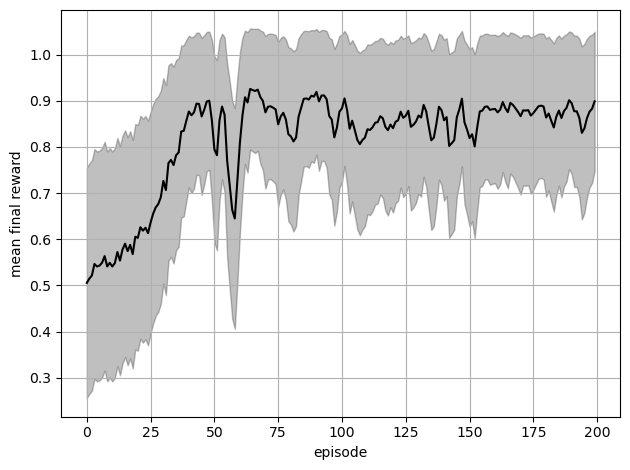

In [9]:
import matplotlib
from matplotlib import pyplot as plt
# static plots
%matplotlib inline 

### plot and examine learning curves

episodes=list(range(N_episodes))

plt.plot(episodes, mean_final_reward, '-k', )
plt.fill_between(episodes, 
                 mean_final_reward-0.5*std_final_reward, 
                 mean_final_reward+0.5*std_final_reward, 
                 color='k', 
                 alpha=0.25)


plt.xlabel('episode')
plt.ylabel('mean final reward')


plt.grid()
plt.tight_layout()

# np.savez('data/PG-quantum_training-p_emit={0:0.3f}-p_ent={1:0.3f}'.format(env.p_emit, env.p_ent),
#               episodes=episodes, 
#               mean_final_reward=mean_final_reward, 
#               std_final_reward=std_final_reward, 
#               min_final_reward=min_final_reward,
#               max_final_reward=max_final_reward,
#               pseudo_loss=p_loss
#          )

plt.show()

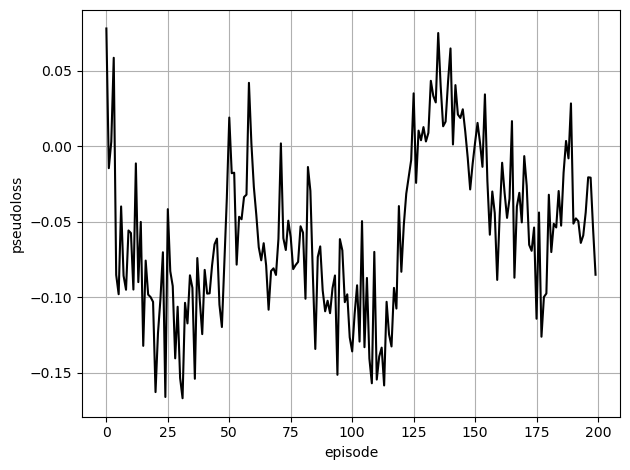

In [10]:
plt.plot(episodes, p_loss, '-k',)

plt.xlabel('episode')
plt.ylabel('pseudoloss')

plt.grid()
plt.tight_layout()
plt.show()

Let us now investigate the agent's behavior starting from the ground state: 

In [14]:
seed=0 # reset seed for reproducibility

# create environment and reset it to a random initial state
env=QuantumEnv(n_time_steps,seed,)
env.reset()

# compute target density matrices
psi = env.psi_tgt.reshape(2,2)
rho_q_tgt = psi @ psi.conj().T  
rho_a_tgt = psi.conj().T @ psi


def process_state(psi):
    psi=psi.reshape(2,2)
    # compute reduced density matrix of qubit before measurement circuit
    rho_q=psi @ psi.conj().T
    #rho_as[time_step,...] = psi.conj().T @ psi # ancilla rdm in down state after measurement
    olap=np.trace(rho_q_tgt@rho_q).real
    # entnaglement entropy
    Sent = np.abs( np.trace(rho_q @ logm(rho_q+np.finfo(np.float64).eps)).real )
    return rho_q, olap, Sent


# run the greedy agent and collect data
rho_qs  = np.zeros((4*env.n_time_steps+1,2,2), dtype=np.complex64) # 4 different states per eipisode, see env.psi_data
olaps   = np.zeros((4*env.n_time_steps+1,)) # 4 different states per eipisode, see env.psi_data
Sents   = np.zeros((4*env.n_time_steps+1,)) # 4 different states per eipisode, see env.psi_data
states  = np.zeros((env.n_time_steps,env.n_time_steps,3),)
protocol= np.zeros((env.n_time_steps,3),)

rho_qs[0,...], olaps[0], Sents[0] = process_state(env.psi)

for time_step in range(env.n_time_steps):

    # select state
    state = env.state
    
    ### select an action according to an agent
    means, stds = predict(current_params, state.ravel()) # trained agent
    #means, stds = predict(initial_params, state.ravel()) # initial untrained agent
    action = means # deterministic testing

    # take an environment step
    _, reward, _ = env.step(action)
    
    # system state
    psi = env.psi_data
    for _k in range(4):
        rho_qs[1+4*time_step+_k,...], olaps[1+4*time_step+_k], Sents[1+4*time_step+_k] = process_state(psi[_k,:])

    states[time_step,...]=env.state
    protocol[time_step,:]=means
    

# np.savez('data/PG-quantum_test-p_emit={0:0.3f}-p_ent={1:0.3f}'.format(env.p_emit, env.p_ent),
#               rho_qs=rho_qs, 
#               olaps=olaps,
#               Sents=Sents,
#               states=states,
#               protocol=protocol,
#               seed=seed,
#          )


Next, we process the data to prepare to plot it on the Bloch sphere

In [15]:
# process data

X =np.array([[0.0,1.0  ], [1.0 , 0.0]])
Y =np.array([[0.0,-1.0j], [1.0j, 0.0]])
Z =np.array([[1.0,0.0  ], [0.0 ,-1.0]])

sigma_vec = np.array([X,Y,Z])

tgt_point = np.einsum('sij,ji->s', sigma_vec, rho_q_tgt).real
points = np.einsum('sij,aji->as', sigma_vec, rho_qs).real

The code below uses Jupyter widgets and a qutip plotting function to visualize the states of the system during the episode. In particular, we plot at each episode step the state after:
* applying the control unitary
* applying the entangling noise unitary
* spontaneous emission
* after the ancilla measurement

Hence, there are 4 times as many steps (20) as there are steps in an episode (5).

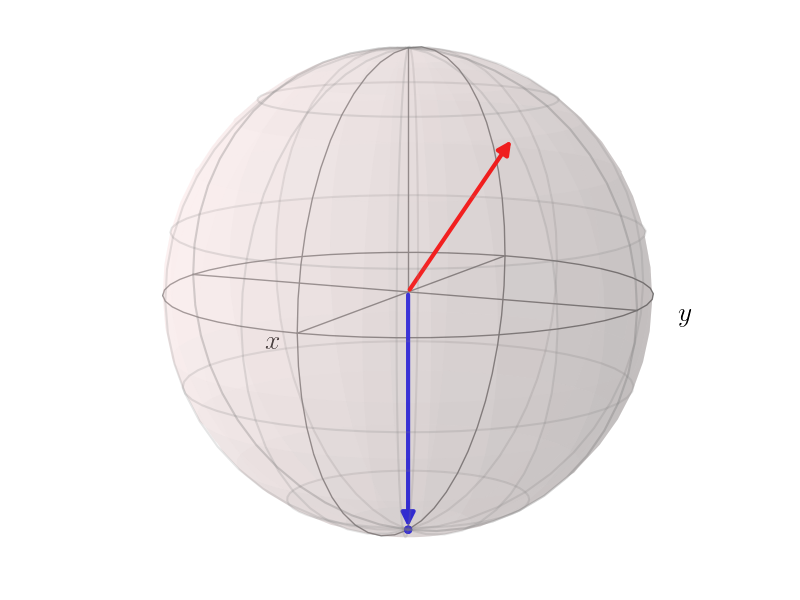

In [16]:
import sys, os
sys.path.append('/Bloch_sphere_lib/')

from Bloch_sphere_lib.qutip_bloch import Bloch

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import IntSlider, interactive, Output, VBox, Button, HBox, Layout
from IPython.display import display, clear_output
from matplotlib.widgets import Slider

%matplotlib widget

# create figure output
output = Output()
with output:
    global sphere #, im_g, bar, cax, cax_g
    ### Create the plots
    fig = plt.figure(figsize=(8, 6))
    ax = Axes3D(fig, auto_add_to_figure=False, azim=-65, elev=10)
    axes = fig.add_axes(ax)
    ### define Bloch sphere fig
    sphere = Bloch(fig=fig, axes=axes)
    sphere.set_label_convention("xy")
    sphere.point_color = ['b']
    sphere.add_vectors([points[0], tgt_point,], colors=['b','r',] )
    ### render fig
    sphere.render()
    ### move the toolbar to the bottom
    fig.canvas.toolbar_position = 'bottom'
    #fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    #fig.canvas.footer_visible = False

# Output widget for text
text_output = Output()
with text_output:
    clear_output(wait=True)
    sphere.clear()
    print("Bloch sphere")

# Function to update the frames
def update(frame_idx):
    global sphere #, im_g, bar, cax, cax_g
    global fig
    ### add quantum data
    sphere.add_vectors([points[frame_idx],], colors=['b',], alpha=1.0-Sents[frame_idx]/np.log(2) )
    sphere.add_vectors([tgt_point,], colors=['r',], )
    sphere.add_points(points[:frame_idx+1].T,)
    ### draw
    sphere.render()
    fig.canvas.draw()
    with text_output:
        ### update text output
        clear_output(wait=True)
        sphere.clear()
        print("target overlap = {0:0.3f}\nentanglement = {1:0.6f}".format(olaps[frame_idx],Sents[frame_idx]))

# Number of frames
n_frames = points.shape[0]

# Create a slider to scroll through frames
frame_slider = IntSlider(value=0, min=0, max=n_frames-1, step=1, description='episode step', layout=Layout(width='500px'))
# Link the slider to the function
slider = interactive(update, frame_idx=frame_slider);

# Function to go to the next frame
def next_frame(b):
    if frame_slider.value < n_frames - 1:
        frame_slider.value += 1
# Function to go to the previous frame
def prev_frame(b):
    if frame_slider.value > 0:
        frame_slider.value -= 1

# Create buttons to go forward and back
button_next = Button(description="Next")
button_next.on_click(next_frame)
button_prev = Button(description="Previous")
button_prev.on_click(prev_frame)

# Layout for the buttons
controls = HBox([button_prev, slider, button_next])


# Display the initial plot and controls
display(VBox([controls, text_output, output], layout=Layout(display='flex', flex_flow='column', justify_content='center', align_items='stretch')))

## Questions

**Q0.** Try out different batch sizes and hyperparameters (including different network architectures). Can you improve the performance?

**Q1.** Explore the final batch of trajectories. Check the sequence of actions. Can you make sense of the solution found by the agent? _Hint: think of the dynamics on the Bloch sphere and try to visualize the trajectory there._

**Q2.** Compare the Policy Gradient method to conventional optimal control: can optimal control give you a control protocol that works for this setup? Why or why not?

**Q3.** Find ways to visualize the policy for each state of the Bloch sphere. What is a meaningful way to do that? 

## Advanced Problems

**A1.** The loop over the $N_{MC}$ trajectories slows down the algorithm significantly. Consider ways to speed up the evaluation of a single PG iteration. This can include a modification of the environment `QubitEnv` or the use of parallelization software (see JAX's functions [`vmap`](https://jax.readthedocs.io/en/latest/jax.html#vectorization-vmap) and [`pmap`](https://jax.readthedocs.io/en/latest/jax.html#parallelization-pmap)). 
    
**A2.** Change the environment `QubitEnv` to define a nonepisodic task (i.e., a task that continues until the terminal state $s_\mathrm{target}$ is reached and does _not_ have a fixed number of steps). In doing so, introduce an additional "stop" action so that when the agent brings the RL state close to the target the episode comes to an end and the environment is reset. This would require you to also modify the Policy Gradient implementation above because episodes now can have different lengths.  